In [259]:
from tsplearn import *
import numpy as np 
import pandas as pd

prob_T=0.97

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1]
nd = B1.shape[1]
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(M*sparsity) # Sparsity
sparsity_mode = "max"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

In [138]:
import os
import pickle

def get_data(dictionary_type, prob_T):

    if prob_T==1:
        name = f'full_data_{dictionary_type}'
    else:
        name = f'top_data_T{int(prob_T*100)}'
    PATH = os.getcwd()
    DIR_PATH = f'{PATH}\\synthetic_data'
    FILENAME = f'{DIR_PATH}\\{name}.pkl'

    try:
        with open(FILENAME, 'rb') as f: 
            load_data = pickle.load(f)
        f.close()
    except Exception as e:
        print(f"Error during data loading: {e}")

    return load_data

load_data = get_data(dictionary_type, prob_T)
D_true = load_data['D_true']
Y_train = load_data['Y_train']
Y_test = load_data['Y_test']
X_train = load_data['X_train']
X_test = load_data['X_test']
epsilon_true =  load_data['epsilon_true']
c_true = load_data['c_true']

In [312]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.data_gen import *
from typing import Tuple, List, Union


def sparse_transform(D, K0, Y_test, Y_train=None):

    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)
    Domp = D @ W
    X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test)
    # Normalization
    X_test = W @ X_test

    if np.all(Y_train == None):

        return X_test
    
    # Same for the training set
    X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train)
    X_train = W @ X_train

    return X_test, X_train



def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)


def _multiplier_search(*arrays, P, c, epsilon):
    is_okay = 0
    mult = 100
    tries = 0
    while is_okay==0:
        is_okay = 1
        h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, P=P, mult=mult)
        if c_try <= c:
            is_okay *= 1
        if tmp_sum_min > c-epsilon:
            is_okay *= 1
            incr_mult = 0
        else:
            is_okay = is_okay*0
            incr_mult = 1
        if tmp_sum_max < c+epsilon:
            is_okay *= 1
            decr_mult = 0
        else:
            is_okay *= 0
            decr_mult = 1
        if is_okay == 0:
            tries += 1
        if tries >3:
            discard = 1
            break
        if incr_mult == 1:
            mult *= 2
        if decr_mult == 1:
            mult /= 2
    return h, discard


def init_dict(Lu: np.ndarray,
              Ld: np.ndarray, 
              P: int, 
              J: int, 
              Y_train: np.ndarray, 
              K0: int,
              dictionary_type: str, 
              c: float, 
              epsilon: float,
              h: np.ndarray = None, 
              only: str = "only_X") -> Tuple[np.ndarray, np.ndarray]:
    """
    Initialize the dictionary and the signal sparse representation for the alternating
    optimization algorithm.

    Args:
        Lu (np.ndarray): Upper Laplacian matrix
        Ld (np.ndarray): Lower Laplacian matrix
        P (int): Number of kernels (sub-dictionaries).
        J (int): Max order of the polynomial for the single sub-dictionary.
        Y_train (np.ndarray): Training data.
        K0 (int): Sparsity of the signal representation.
        dictionary_type (str): Type of dictionary.
        c (float): Boundary constant from the synthetic data generation process.
        epsilon (float): Boundary constant from the synthetic data generation process.
        only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

    Returns:
        Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
    """

    M = Lu.shape[0]
    D = np.zeros((M, M*P))
    X = np.zeros(Y_train.shape)
    X = np.tile(X, (P,1))
    discard = 1

    if (only == "only_D") or (only == "all"):
        
        while discard==1:

            if dictionary_type == "joint":
                Lj, lambda_max_j, lambda_min_j = compute_Lj_and_lambdaj(Lu + Ld, J)
                h, discard = _multiplier_search(lambda_max_j, lambda_min_j, P=P, c=c, epsilon=epsilon)
                D = generate_dictionary(h, P, Lj)

            elif dictionary_type == "edge_laplacian":
                Lj, lambda_max_j, lambda_min_j = compute_Lj_and_lambdaj(Ld, J)
                h, discard = _multiplier_search(lambda_max_j, lambda_min_j, P=P, c=c, epsilon=epsilon)
                D = generate_dictionary(h, P, Lj)

            elif dictionary_type == "separated":
                Luj, lambda_max_u_j, lambda_min_u_j = compute_Lj_and_lambdaj(Lu, J, separated=True)
                Ldj, lambda_max_d_j, lambda_min_d_j = compute_Lj_and_lambdaj(Ld, J, separated=True)
                h, discard = _multiplier_search(lambda_max_d_j, lambda_min_d_j, lambda_max_u_j, lambda_min_u_j, P=P, c=c, epsilon=epsilon)
                D = generate_dictionary(h, P, Luj, Ldj)
    
    if (only == "only_X" or only == "all"):
        
        if dictionary_type == "edge_laplacian":
            L = Ld
        else:
            L = Lu+Ld

        # If no prior info on the dictionary simply do the Fourier transform
        if h==None:
            _, Dx = sla.eig(L)
            dd = la.norm(Dx, axis=0)
            W = np.diag(1./dd)
            Dx = Dx / la.norm(Dx)  
            Domp = Dx@W
            X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train)
            X = np.tile(X, (P,1))
        # Otherwise use prior info about the dictionary to initialize the sparse representation
        else:
            if dictionary_type == "separated":
                Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
                Ldj = np.array([la.matrix_power(Ld, i) for i in range(1, J + 1)])
                D = generate_dictionary(h, P, Luj, Ldj)
                X = sparse_transform(D, K0, Y_train)
            else: 
                Lj = np.array([la.matrix_power(L, i) for i in range(1, J + 1)])
                D = generate_dictionary(h, P, Lj)
                X = sparse_transform(D, K0, Y_train)                
        
    return D, X


def topological_dictionary_learn(Y_train: np.ndarray,
                                 Y_test: np.ndarray, 
                                 J: int, 
                                 M: int, 
                                 P: int,
                                 D0: np.ndarray, 
                                 X0: np.ndarray, 
                                 Lu: np.ndarray, 
                                 Ld: np.ndarray,
                                 dictionary_type: str, 
                                 c: float, 
                                 epsilon: float, 
                                 K0: int,
                                 lambda_: float = 1e-3, 
                                 max_iter: int = 10, 
                                 patience: int = 10,
                                 tol: float = 1e-7, 
                                 verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
    The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
    for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
    the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
    Args:
        Y_train (np.ndarray): Training data.
        Y_test (np.ndarray): Testing data.
        J (int): Max order of the polynomial for the single sub-dictionary.
        M (int): Number of data points (number of nodes in the data graph).
        P (int): Number of kernels (sub-dictionaries).
        D0 (np.ndarray): Initial dictionary.
        X0 (np.ndarray): Initial sparse representation.
        Lu (np.ndarray): Upper Laplacian matrix
        Ld (np.ndarray): Lower Laplacian matrix
        dictionary_type (str): Type of dictionary.
        c (float): Boundary constant from the synthetic data generation process.
        epsilon (float): Boundary constant from the synthetic data generation process.
        K0 (int): Sparsity of the signal representation.
        lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
        max_iter (int, optional): Maximum number of iterations. Defaults to 10.
        patience (int, optional): Patience for early stopping. Defaults to 10.
        tol (float, optional): Tolerance value. Defaults to 1e-s.
        verbose (int, optional): Verbosity level. Defaults to 0.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
         minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
    """

    # Define hyperparameters
    Ldj = 0
    min_error_train, min_error_test = 1e20, 1e20
    m_test, m_train = Y_test.shape[1], Y_train.shape[1]
    iter_, pat_iter = 1, 0
    history = []

    if dictionary_type != "fourier":
        if dictionary_type=="joint":
            Lj, _, _ = compute_Lj_and_lambdaj(Lu + Ld, J)
        elif dictionary_type=="edge_laplacian":
            Lj, _, _ = compute_Lj_and_lambdaj(Ld, J)
        elif dictionary_type=="separated":
            Luj, _, _ = compute_Lj_and_lambdaj(Lu, J, separated=True)
            Ldj, _, _ = compute_Lj_and_lambdaj(Ld, J, separated=True)

        # Init the dictionary and the sparse representation 
        D_coll = [cp.Constant(D0[:,(M*i):(M*(i+1))]) for i in range(P)]
        Y = cp.Constant(Y_train)
        X_train = X0
        
        while pat_iter < patience and iter_ <= max_iter:
            
            # SDP Step
            # Init constants and parameters
            D_coll = [cp.Constant(np.zeros((M, M))) for i in range(P)] 
            Dsum = cp.Constant(np.zeros((M, M)))
            X = cp.Constant(X_train)
            I = cp.Constant(np.eye(M))
            
            # Define the objective function
            if dictionary_type in ["joint", "edge_laplacian"]:
                # Init the variables
                h = cp.Variable((P, J))
                hI = cp.Variable((P, 1))
                for i in range(0,P):
                    tmp =  cp.Constant(np.zeros((M, M)))
                    for j in range(0,J):
                        tmp += (cp.Constant(Lj[j, :, :]) * h[i,j])
                    tmp += (I*hI[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(P)])
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3)

            else:
                # Init the variables
                hI = cp.Variable((P, J))
                hS = cp.Variable((P, J))
                hH = cp.Variable((P, 1))
                for i in range(0,P):
                    tmp =  cp.Constant(np.zeros((M, M)))
                    for j in range(0,J):
                        tmp += ((cp.Constant(Luj[j, :, :])*hS[i,j]) + (cp.Constant(Ldj[j, :, :])*hI[i,j]))
                    tmp += (I*hH[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(P)])
                
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3 + term4)

            # Define the constraints
            constraints = [D_coll[i] >> 0 for i in range(P)] + \
                            [(cp.multiply(c, I) - D_coll[i]) >> 0 for i in range(P)] + \
                            [(Dsum - cp.multiply((c - epsilon), I)) >> 0, (cp.multiply((c + epsilon), I) - Dsum) >> 0]

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.MOSEK, verbose=False)
            # Update the dictionary
            D = D.value

            # OMP Step
            X_test, X_train = sparse_transform(D, K0, Y_test, Y_train)

            # Error Updating
            error_train = nmse(D, X_train, Y_train, m_train)
            error_test= nmse(D, X_test, Y_test, m_test)

            history.append(error_test)
            
            # Error Storing
            if (error_train < min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - min_error_train) > tol):
                X_opt_train = X_train
                min_error_train = error_train

            if (error_test < min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - min_error_test) > tol):
                h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else [hS.value, hI.value, hH.value]
                D_opt = D
                X_opt_test = X_test
                min_error_test = error_test
                pat_iter = 0

                if verbose == 1:
                    print("New Best Test Error:", min_error_test)
            else:
                pat_iter += 1

            iter_ += 1
    
    else:

        # Fourier Dictionary Benchmark
        L = Lu + Ld
        _, D_opt = sla.eigh(L)
        X_test, X_train = sparse_transform(D_opt, K0, Y_test, Y_train)

        # Error Updating
        min_error_train = nmse(D, X_train, Y_train, m_train)
        min_error_test= nmse(D, X_test, Y_test, m_test)
        h_opt = 0
        
    return min_error_test, min_error_test, h_opt, X_opt_test, X_opt_train, D_opt, Ldj, history


def indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)


def compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj


def learn_upper_laplacian(Y_train: np.ndarray,
                          Y_test: np.ndarray, 
                          J: int, 
                          M: int, 
                          P: int,
                          Lu: np.ndarray, 
                          Ld: np.ndarray,
                          dictionary_type: str, 
                          c: float, 
                          epsilon: float, 
                          K0: int,
                          B2: np.ndarray,
                          history: List[np.ndarray] = [],
                          filter: np.ndarray = 1,
                          current_min: float = None,
                          h_opt: np.ndarray = None,
                          lambda_: float = 1e-3, 
                          max_iter: int = 10, 
                          patience: int = 10,
                          tol: float = 1e-7, 
                          verbose: bool = False):
    
    # assert np.all(current_min!=B2), "You must provide the edge-triangle incidence matrix B2."

    # Check if we are executing the first recursive iteration
    if current_min == None:
        current_min = np.inf
        T = B2.shape[1]
        filter = np.ones(T)


    D0, X0 = init_dict(Lu=Lu,
                        Ld=Ld,
                        P=P,
                        J=J,
                        Y_train=Y_train,
                        K0=K0,
                        dictionary_type=dictionary_type,
                        c=c,
                        epsilon=epsilon,
                        h=h_opt,
                        only="only_X")

    _, min_error_test, h_opt, X_opt_test, _, D_opt, Ldj, hist = topological_dictionary_learn(Y_train=Y_train,
                                                                                    Y_test=Y_test,
                                                                                    J=J,
                                                                                    M=M,
                                                                                    P=P,
                                                                                    D0=D0,
                                                                                    X0=X0,
                                                                                    Lu=Lu,
                                                                                    Ld=Ld,
                                                                                    dictionary_type=dictionary_type,
                                                                                    c=c,
                                                                                    epsilon=epsilon,
                                                                                    K0=K0,
                                                                                    lambda_=lambda_,
                                                                                    max_iter=max_iter,
                                                                                    patience=patience,
                                                                                    tol=tol)
    history.append(hist)
    search_space = np.where(filter == 1)    
    sigmas = pd.DataFrame({"idx": search_space[0]})

    sigmas["sigma"] = sigmas.idx.apply(lambda x: filter)
    sigmas["sigma"] = sigmas.apply(lambda x: indicator_matrix(x), axis=1)
    sigmas["Luj"] = sigmas.apply(lambda x: compute_Luj(x, B2, J), axis=1)
    sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(h_opt, P, x.Luj, Ldj), axis=1)
    sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, k0, Y_test))
    sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, Y_test, m_test), axis=1)
    
    candidate_error = sigmas.NMSE.min()
    idx_min = sigmas.NMSE.idxmin()

    if candidate_error < min_error_test:
        S = sigmas.sigma[idx_min]
        Lu_new = B2 @ S @ B2.T
        current_min = candidate_error
        filter = np.diagonal(S)

        if verbose:
            print(f'Removing 1 triangle from topology... \n ... New min test error: {current_min} !')

        return learn_upper_laplacian(Y_train=Y_train,
                                    Y_test=Y_test,
                                    J =J,
                                    M=M,
                                    P=P,
                                    Lu=Lu_new,
                                    Ld=Ld,
                                    dictionary_type=dictionary_type,
                                    c=c,
                                    epsilon=epsilon,
                                    K0=K0,
                                    h_opt=h_opt,
                                    history=history,
                                    filter=filter,
                                    current_min=current_min,
                                    B2=B2,
                                    lambda_=lambda_,
                                    max_iter=max_iter,
                                    patience=patience,
                                    tol=tol,
                                    verbose=verbose)

    return min_error_test, history, Lu, h_opt, X_opt_test, D_opt

In [158]:
# # global B2, h_opt, J


# def indicator_matrix(row):
#     tmp = row.sigma.copy()
#     tmp[row.idx] = 0
#     return np.diag(tmp)

# def compute_Luk(row, b2, J):
#     Lu = b2 @ row.sigma @ b2.T
#     Luk = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
#     return Luk

# def greedy_search(Y_test: np.ndarray, 
#                     J: int, 
#                     P: int,
#                     m_test:int,
#                     Ldk: np.ndarray,
#                     h_opt: np.ndarray, 
#                     K0: int,
#                     B2: np.ndarray,
#                     filter: np.ndarray = 1):

#     search_space = np.where(filter == 1)    
#     sigmas = pd.DataFrame({"idx": search_space[0]})

#     sigmas["sigma"] = sigmas.idx.apply(lambda x: filter)
#     sigmas["sigma"] = sigmas.apply(lambda x: indicator_matrix(x), axis=1)
#     sigmas["Luk"] = sigmas.apply(lambda x: compute_Luk(x, B2, J), axis=1)
#     sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(h_opt, P, x.Luk, Ldk), axis=1)
#     sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, K0, Y_test))
#     sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, Y_test, m_test), axis=1)

#     return sigmas


# def learn_upper_laplacian(Y_train: np.ndarray,
#                           Y_test: np.ndarray, 
#                           J: int, 
#                           M: int, 
#                           P: int,
#                           m_test: int,
#                           Lu: np.ndarray, 
#                           Ld: np.ndarray,
#                           dictionary_type: str, 
#                           c: float, 
#                           epsilon: float, 
#                           K0: int,
#                           B2: np.ndarray,
#                           filter: np.ndarray = 1,
#                           current_min: float = None,
#                           lambda_: float = 1e-3, 
#                           max_iter: int = 10, 
#                           patience: int = 10,
#                           tol: float = 1e-7, 
#                           verbose: bool = False):
    
    
#     Ldk,_,_= compute_Lj_and_lambdaj(Ld, J)

#     D0, X0, _ = initialize_dic(Lu=Lu,
#                                Ld=Ld,
#                                P=P,
#                                J=J,
#                                Y_train=Y_train,
#                                K0=K0,
#                                dictionary_type=dictionary_type,
#                                c=c,
#                                epsilon=epsilon,
#                                only="only_X")

#     _, min_error_test, h_opt, X_opt_test, _, D_opt, Ldk, history = topological_dictionary_learn(Y_train=Y_train,
#                                                                                     Y_test=Y_test,
#                                                                                     J=J,
#                                                                                     M=M,
#                                                                                     P=P,
#                                                                                     D0=D0,
#                                                                                     X0=X0,
#                                                                                     Lu=Lu,
#                                                                                     Ld=Ld,
#                                                                                     dictionary_type=dictionary_type,
#                                                                                     c=c,
#                                                                                     epsilon=epsilon,
#                                                                                     K0=K0,
#                                                                                     lambda_=lambda_,
#                                                                                     max_iter=max_iter,
#                                                                                     patience=patience,
#                                                                                     tol=tol)
#     tot_hist = []
#     Lu_opt = Lu
#     current_min = -np.inf
#     T = B2.shape[1]
#     filter = np.ones(T)

#     while current_min<min_error_test:
        
#         sigmas = greedy_search(Y_test,
#                                 J,
#                                 P,
#                                 m_test,
#                                 Ldk,
#                                 h_opt,
#                                 K0,
#                                 B2,
#                                 filter)
    
#         current_min = sigmas.NMSE.min()
#         idx_min = sigmas.NMSE.idxmin()
#         print(current_min)
#         if current_min < min_error_test:
#             S = sigmas.sigma[idx_min]
#             Lu_opt = B2 @ S @ B2.T
#             filter = np.diagonal(S)

#             D0, X0, _ = initialize_dic(Lu=Lu,
#                             Ld=Ld,
#                             P=P,
#                             J=J,
#                             Y_train=Y_train,
#                             K0=K0,
#                             dictionary_type=dictionary_type,
#                             c=c,
#                             epsilon=epsilon,
#                             only="only_X")

#             _, min_error_test, h_opt, X_opt_test, _, D_opt, Ldk, history = topological_dictionary_learn(Y_train=Y_train,
#                                                                                             Y_test=Y_test,
#                                                                                             J=J,
#                                                                                             M=M,
#                                                                                             P=P,
#                                                                                             D0=D0,
#                                                                                             X0=X0,
#                                                                                             Lu=Lu_opt,
#                                                                                             Ld=Ld,
#                                                                                             dictionary_type=dictionary_type,
#                                                                                             c=c,
#                                                                                             epsilon=epsilon,
#                                                                                             K0=K0,
#                                                                                             lambda_=lambda_,
#                                                                                             max_iter=max_iter,
#                                                                                             patience=patience,
#                                                                                             tol=tol)

#             tot_hist.append(history)

#             if verbose:
#                 print(f'Removing 1 triangle from topology... \n ... New min test error: {current_min} !')

#     return min_error_test, tot_hist, Lu_opt, h_opt, X_opt_test, D_opt


In [310]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

D0, X0,L, Dx = init_dict(Lu, Ld, P, J, Y_train[:, :, s], k0, dictionary_type, c, epsilon, only="only_X")

# min_error_test, min_error_test, h_opt, X_opt_test, X_opt_train, D_opt, Ldj, history = topological_dictionary_learn(Y_train[:,:,s], Y_test[:,:,s],
#                                                                                                                         J, M, P, D0, X0, Lu_full, Ld, "separated",
#                                                                                                                         c, epsilon, k0, lambda_, max_iter,
#                                                                                                                         patience, tol)

here


In [251]:
D01, X01, L2, Dx2 = init_dict(Lu, Ld, P, J, Y_train[:, :, s], k0, dictionary_type, c, epsilon, only="only_X")


here


In [261]:
np.all(L2==L)

False

In [182]:
np.all(X0 == X01)

True

In [313]:
import warnings

warnings.filterwarnings('ignore')

min_error_test, history, Lu_opt, h_opt, X_opt_test, D_opt = learn_upper_laplacian(B2=B2,
                                                                            Y_train=Y_train[:,:,s],
                                                                            Y_test=Y_test[:,:,s],
                                                                            J=J,
                                                                            M=M,
                                                                            P=P,
                                                                            Lu=Lu_full,
                                                                            Ld=Ld,
                                                                            dictionary_type=dictionary_type,
                                                                            c=c,
                                                                            epsilon=epsilon,
                                                                            K0=k0,
                                                                            lambda_=lambda_,
                                                                            max_iter=max_iter,
                                                                            patience=patience,
                                                                            tol=tol,
                                                                            verbose=verbose)

Removing 1 triangle from topology... 
 ... New min test error: 0.005354171298820855 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004416565597402029 !


In [19]:
name = f'learn_T{int(prob_T*100)}'
save_var = {"min_error_test" : min_error_test,
            "history" : history,
            "Lu" : Lu,
            "h_opt" : h_opt,
            "X_opt_test" : X_opt_test,
            "D_opt" : D_opt}

path = os.getcwd()
dir_path = f'{path}\\results\\topology_learning'
filename = f'{dir_path}\\{name}.pkl'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
try:
    with open(filename, 'wb') as f:
        pickle.dump(save_var, f)
except IOError as e:
    print(f"An error occurred while writing the file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

f.close()

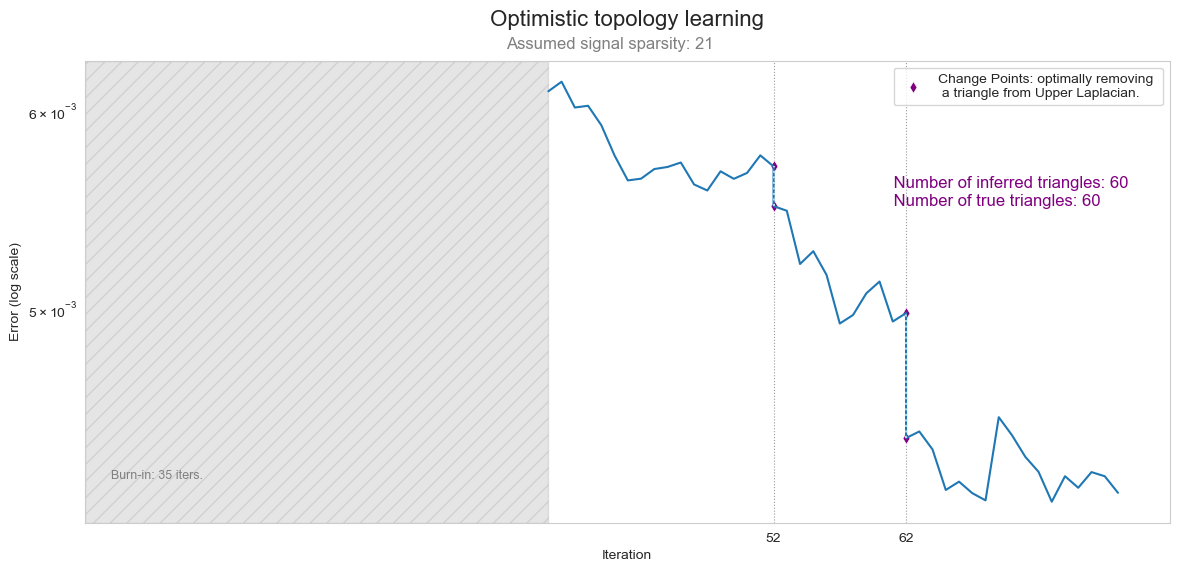

In [314]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

burn_in = 0.65
start_iter = 0
end_iter = 0
change_points = []
change_points_y1 = []
change_points_y2 = []
burn_in_iter = 0
his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)
    change_points_y1.append(h[-1])
    change_points_y2.append(h[0])

plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                   'x':xx[burn_in_iter:]})

change_points = np.array(change_points[:-1])
change_points_y1 = np.array(change_points_y1[:-1])
change_points_y2 = np.array(change_points_y2[1:])
# change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

# Change-points
sns.scatterplot(x=np.hstack([change_points, change_points]),
                 y=np.hstack([change_points_y1, change_points_y2]),
                 label='Change Points: optimally removing \n a triangle from Upper Laplacian.',
                 color='purple', marker='d')

plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
           ymax=change_points_y1, ymin=change_points_y2)

# Burn-in area
plt.axvspan(0, burn_in_iter, color='grey', step_h=0.2, hatch='//')

my_plt.set_title(f'Optimistic topology learning',fontsize=16, pad=25)
plt.suptitle(f'Assumed signal sparsity: {k0}', fontsize=12, color='gray', x=0.5, y=0.92)
plt.text(y=plt_data.y.iloc[0]*0.7, x=2, s=f'Burn-in: {burn_in_iter} iters.', fontsize=9, color='gray')
plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {nu-T}',
         y=plt_data.y.iloc[0]*0.9, x=len(his)*0.75, fontsize=12, color='purple')
my_plt.set_xlabel('Iteration')
my_plt.set_ylabel('Error (log scale)')
plt.xticks(change_points)
plt.yticks([])
plt.xlim(left=0)
plt.yscale('log')
plt.show() 

In [324]:
a,b,c = [1,2,3]

In [325]:
a

1

In [ ]:
# import warnings

# warnings.filterwarnings('ignore')

# min_error_test, tot_hist, Lu_opt, h_opt, X_opt_test, D_opt = learn_upper_laplacian(B2=B2,
#                                                         Y_train=Y_train[:,:,s],
#                                                         Y_test=Y_test[:,:,s],
#                                                         J=J,
#                                                         M=M,
#                                                         P=P,
#                                                         m_test=m_test,
#                                                         Lu=Lu_full,
#                                                         Ld=Ld,
#                                                         dictionary_type=dictionary_type,
#                                                         c=c,
#                                                         epsilon=epsilon,
#                                                         K0=k0,
#                                                         lambda_=lambda_,
#                                                         max_iter=max_iter,
#                                                         patience=patience,
#                                                         tol=tol,
#                                                         verbose=verbose)

# The class

In [347]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.data_gen import *
from tsplearn.tsp_utils import EnhancedGraph
from typing import Tuple, List, Union, Dict

def _indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)

def _compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj

def sparse_transform(D, K0, Y_te, Y_tr=None):

    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)
    Domp = D @ W
    X_te = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_te)
    # Normalization
    X_te = W @ X_te

    if np.all(Y_tr == None):

        return X_te
    
    # Same for the training set
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_tr)
    X_tr = W @ X_tr
    
    return X_te, X_tr

def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)


class TopologyLearner:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
                'P': None,      # Number of Kernels (Sub-dictionaries)
                'J': None,      # Polynomial order
                'K0': None,     # Sparsity level
                'dictionary_type': None,
                'c': None,      # spectral control parameter 
                'epsilon': None,# spectral control parameter
                'n': 10,        # number of nodes
                'sub_size': None,   # Number of sub-sampled nodes
                'prob_T': 1.,   # Ratio of colored triangles
                'p_edges': 1.,  # Probability of edge existence
                'seed': None
                }
        
        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError("When using positional arguments, must provide a single dictionary")
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data
        self.G = EnhancedGraph(n=params['n'],
                               p_edges=params['p_edges'], 
                               p_triangles=params['prob_T'], 
                               seed=params['seed'])
        self.B1: np.ndarray = self.G.get_b1()
        self.B2: np.ndarray = self.G.get_b2()

        # Sub-sampling if needed to decrease complexity
        if params['sub_size'] != None:
            self.B1 = self.B1[:, :params['sub_size']]
            self.B2 = self.B2[:params['sub_size'], :]
            self.B2 = self.B2[:,np.sum(np.abs(self.B2), 0) == 3]
        self.nu: int = self.B2.shape[1]
        self.nd: int = self.B1.shape[1]
        self.T: int = int(np.ceil(self.nu*(1-params['prob_T'])))

        # Laplacians
        Lu, Ld, L = self.G.get_laplacians(sub_size=params['sub_size'])
        self.Lu: np.ndarray = Lu
        self.Ld: np.ndarray = Ld
        self.L: np.ndarray = L
        self.Lu_full: np.ndarray = G.get_laplacians(sub_size=params['sub_size'], 
                                                    full=True)
        self.M =  L.shape[0]
        self.history: List[np.ndarray] = []

        # Dictionary, parameters and hyperparameters for compression
        self.P = params['P']
        self.J = params['J']
        self.c = params['c']
        self.epsilon = params['epsilon']
        self.K0 = params['K0']
        self.dictionary_type = params['dictionary_type']
        self.D_opt: np.ndarray = np.zeros((self.M, self.M*self.P))

        if self.dictionary_type=="separated":
            hs = np.zeros((self.P,self.J))
            hi = np.zeros((self.P,self.J))
            hh = np.zeros((self.P,1))
            self.h_opt: List[np.ndarray] = [hs,hi,hh]
        else:
            self.h_opt: np.ndarray = np.zeros((self.P*(self.J+1),1))
            
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)

        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.L, self.J)
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.Ld, self.J)
        elif  self.dictionary_type == 'separated':
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, self.J, separated=True)
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(self.Ld, self.J, separated=True)

        # Init the learning errors
        self.min_error_train = 1e20
        self.min_error_test = 1e20

    # def fit(self) -> Tuple[float, List[np.ndarray], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #     min_error_test, _, _, h_opt, X_opt_test, D_opt = self.learn_upper_laplacian()
    #     return min_error_test, self.history, params['Lu'], h_opt, X_opt_test, D_opt

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, 
                                                                                    self.J, 
                                                                                    separated=True)

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, P=P, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(self,
                  h_prior: np.ndarray = None, 
                  mode: str = "only_X") -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """
        
        # If no prior info on the dictionary
        if np.all(h_prior == None):

            if (mode in ["all","only_D"]):

                discard = 1
                while discard==1:

                    if dictionary_type != "separated":
                        h_prior, discard = _multiplier_search(self.lambda_max_j, 
                                                              self.lambda_min_j, 
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Lj)

                    else:
                        h_prior, discard = _multiplier_search(self.lambda_max_d_j, 
                                                              self.lambda_min_d_j, 
                                                              self.lambda_max_u_j, 
                                                              self.lambda_min_u_j,
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Luj, 
                                                         self.Ldj)
        
            if (mode in ["all","only_X"]):
                
                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1./dd)
                Dx = Dx / la.norm(Dx)  
                Domp = Dx@W
                X = np.apply_along_axis(lambda x: get_omp_coeff(self.K0, Domp.real, x), axis=0, arr=self.Y_train)
                X = np.tile(X, (self.P,1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize the sparse representation
        else:
            
            self.h_opt = h_prior

            if dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Luj, 
                                                 self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)
            else: 
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)             
            

    def topological_dictionary_learn(self,
                                     lambda_: float = 1e-3, 
                                     max_iter: int = 10, 
                                     patience: int = 10,
                                     tol: float = 1e-7,
                                     step_h: float = 1.,
                                     step_x: float = 1.,
                                     solver: str ="MOSEK", 
                                     verbose: bool = False) -> List[np.ndarray]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        if self.dictionary_type != "fourier":

            # Init the dictionary and the sparse representation 
            D_coll = [cp.Constant(self.D_opt[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))
            
            while pat_iter < patience and iter_ <= max_iter:
                
                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [cp.Constant(D[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))
                
                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    h.value = h_opt
                    hI = cp.Variable((self.P, 1))
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += (cp.Constant(self.Lj[j, :, :]) * h[i,j])
                        tmp += (I*hI[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i]for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hS.value, hI.value, hH.value = h_opt
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += ((cp.Constant(self.Luj[j, :, :])*hS[i,j]) + (cp.Constant(self.Ldj[j, :, :])*hI[i,j]))
                        tmp += (I*hH[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
        
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                    term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = [D_coll[i] >> 0 for i in range(self.P)] + \
                                [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)] + \
                                [(Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0, (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Dictionary Update
                D = D.value
                if dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = h_opt + step_h*(h.value - h_opt)
                else:
                    h_opt = [h_opt[0] + step_h*(hS.value-h_opt[0]), 
                             h_opt[1] + step_h*(hI.value-h_opt[1]), 
                             h_opt[2] + step_h*(hH.value-h_opt[2])]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)

            # Error Updating
            self.min_error_train = nmse(D, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(D, self.X_opt_test, self.Y_test, self.m_test)
            
        return self.min_error_test, self.min_error_train, hist
    
    def learn_upper_laplacian(self,
                              Lu_new: np.ndarray = None,
                              filter: np.ndarray = 1,
                              h_prior: np.ndarray = None,
                              lambda_: float = 1e-3, 
                              max_iter: int = 10, 
                              patience: int = 10,
                              tol: float = 1e-7,
                              step_h: float = 1.,
                              step_x: float = 1., 
                              verbose: bool = False):
    
        # assert np.all(current_min!=B2), "You must provide the edge-triangle incidence matrix B2."
        
        
        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = B2.shape[1]
            filter = np.ones(T)
        else:
            self.update_Lu(Lu_new)

        self.init_dict(h_prior=h_prior,
                       mode="only_X")

        _, _, hist = self.topological_dictionary_learn(lambda_=lambda_,
                                                        max_iter=max_iter,
                                                        patience=patience,
                                                        tol=tol,
                                                        step_h=step_h,
                                                        step_x=step_x)
        self.history.append(hist)
        search_space = np.where(filter == 1)    
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda x: filter)
        sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: _compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1)
        sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, self.K0, self.Y_test))
        sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, self.Y_test, self.m_test), axis=1)
        
        candidate_error = sigmas.NMSE.min()
        idx_min = sigmas.NMSE.idxmin()

        if candidate_error < self.min_error_test:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)

            if verbose:
                print(f'Removing 1 triangle from topology... \n ... New min test error: {candidate_error} !')

            return self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              verbose=verbose)

        return self.min_error_test, self.history, self.Lu

    ######### MAYBE ADD STATIC METHODS FOR THESE FUNCTIONS

    # def generate_coeffs(self, arrays: List[np.ndarray], P: int, mult: int) -> Tuple[np.ndarray, float, int, float, float]:
    #     # Your implementation here
    #     pass

    # def generate_dictionary(self, h: np.ndarray, P: int, *args: np.ndarray) -> np.ndarray:
    #     # Your implementation here
    #     pass

    # def compute_Lj_and_lambdaj(self, L: np.ndarray, J: int) -> Tuple[np.ndarray, float, float]:
    #     # Your implementation here
    #     pass


In [354]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topoX=TopologyLearner(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

min_error_test, history, Lu_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              step_h=0.3,
                                                              step_x=0.96,
                                                              verbose=True)

Removing 1 triangle from topology... 
 ... New min test error: 0.005043858724732434 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004633120370490414 !


In [294]:
min_error_test, history, Lu_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              verbose=True)

Removing 1 triangle from topology... 
 ... New min test error: 0.0053541709174353596 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004416565251797768 !


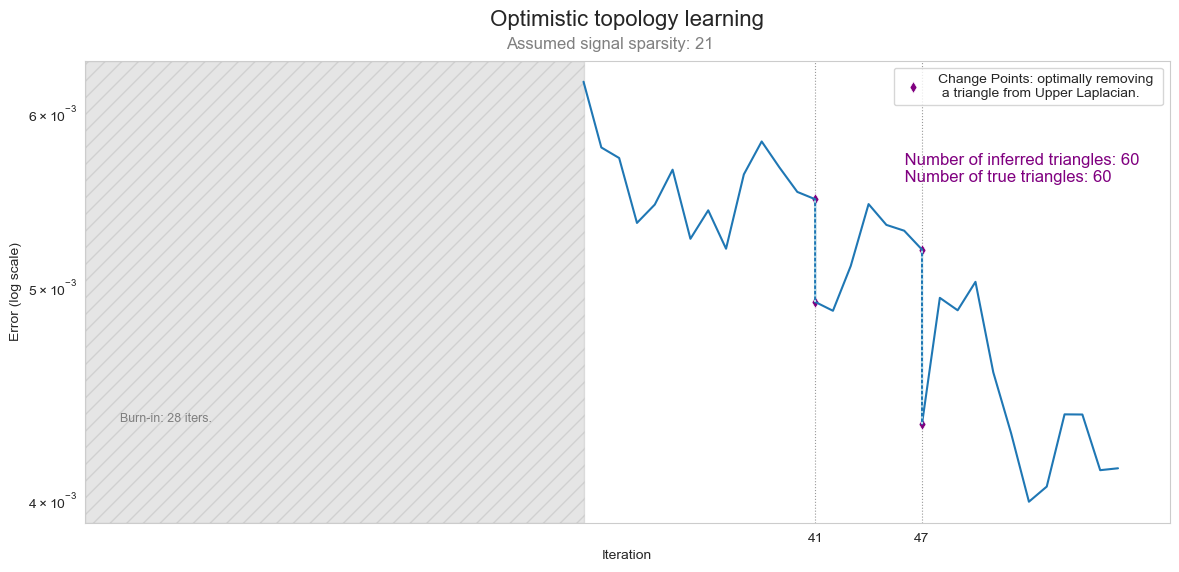

In [355]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

burn_in = 0.65
start_iter = 0
end_iter = 0
change_points = []
change_points_y1 = []
change_points_y2 = []
burn_in_iter = 0
his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)
    change_points_y1.append(h[-1])
    change_points_y2.append(h[0])

plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                   'x':xx[burn_in_iter:]})

change_points = np.array(change_points[:-1])
change_points_y1 = np.array(change_points_y1[:-1])
change_points_y2 = np.array(change_points_y2[1:])
# change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

# Change-points
sns.scatterplot(x=np.hstack([change_points, change_points]),
                 y=np.hstack([change_points_y1, change_points_y2]),
                 label='Change Points: optimally removing \n a triangle from Upper Laplacian.',
                 color='purple', marker='d')

plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
           ymax=change_points_y1, ymin=change_points_y2)

# Burn-in area
plt.axvspan(0, burn_in_iter, color='grey', alpha=0.2, hatch='//')

my_plt.set_title(f'Optimistic topology learning',fontsize=16, pad=25)
plt.suptitle(f'Assumed signal sparsity: {k0}', fontsize=12, color='gray', x=0.5, y=0.92)
plt.text(y=plt_data.y.iloc[0]*0.7, x=2, s=f'Burn-in: {burn_in_iter} iters.', fontsize=9, color='gray')
plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {nu-T}',
         y=plt_data.y.iloc[0]*0.9, x=len(his)*0.75, fontsize=12, color='purple')
my_plt.set_xlabel('Iteration')
my_plt.set_ylabel('Error (log scale)')
plt.xticks(change_points)
plt.yticks([])
plt.xlim(left=0)
plt.yscale('log')
plt.show() 

In [130]:
min_error_test

0.0035390334619995944